In [1]:
import torch
import torch.nn as nn

In [2]:
class PatchEmbed(nn.Module):
  def __init__(self, img_size, patch_size, in_channels=3, embed_dim=768):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size) ** 2

    self.proj = nn.Conv2d(
        in_channels,
        embed_dim,
        kernel_size = patch_size,
        stride=patch_size
    )

  def forward(self, x):
    """
    x: (n_samples, in_chans, img_size, img_size)
    op: (n_samples, n_patches, embed_dim)
    """
    x = self.proj(x) # (n_samples, embed_dim, n_patches**0.5, n_patches**0.5)
    x = x.flatten(2) # (n_samples, embed_dim, n_patches)
    x = x.transpose(1, 2) # (n_samples, n_patches, embed_dim)

    return x

In [18]:
class Attention(nn.Module):
  def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    self.atten_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    """
    x= o/p = (n_samples, n_patches + 1, dim)
    """
    n_samples, n_tokens, dim = x.shape

    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x) # (n_samples, n_patches + 1, 3*dim)
    qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4) #(3, n_samples, n_heads, n_tokens, head_dim)
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1) # (n_samples, n_heads, head_dim, n_tokens)
    dp = (q @ k_t) * self.scale #(n_samples, n_heads, n_tokens, n_tokens)
    attn = dp.softmax(dim=-1)
    attn = self.atten_drop(attn)

    weighted_avg = attn @ v # (n_samples, n_heads, n_tokens, head_dim)
    weighted_avg = weighted_avg.transpose(1,2) # (n_samples, n_tokens, n_head, head_dim)
    weighted_avg = weighted_avg.flatten(2) # flatten last two dim #(n_samples, n_tokens, dim)
    x = self.proj(weighted_avg)
    x = self.proj_drop(x)

    return x

In [4]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        Returns

            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x

In [5]:
class Block(nn.Module):
    """Transformer block.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """
        x : `(n_samples, n_patches + 1, dim)`.

        Returns
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

In [6]:
class VisionTransformer(nn.Module):
  def __init__(self,
               img_size=384,
               patch_size=16,
               in_channels=3,
               n_classes=1000,
               embed_dim=768,
               depth=12,
               n_heads=12,
               mlp_ratio=4.,
               qkv_bias=True,
               p=0.,
               atten_p=0.,):
    super().__init__()

    self.patch_embed = PatchEmbed(
                  img_size=img_size,
                  patch_size=patch_size,
                  in_channels=in_channels,
                  embed_dim=embed_dim,
    )

    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(
        torch.zeros(1, 1+ self.patch_embed.n_patches, embed_dim)
    )
    self.pos_drop = nn.Dropout(p=p)
    self.blocks = nn.ModuleList(
        [
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=atten_p,
            )
            for _ in range(depth)
        ]
    )

    self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)

  def forward(self, x):
      """Run the forward pass.

      Parameters
      ----------
      x : torch.Tensor
          Shape `(n_samples, in_chans, img_size, img_size)`.

      Returns
      -------
      logits : torch.Tensor
          Logits over all the classes - `(n_samples, n_classes)`.
      """
      n_samples = x.shape[0]
      x = self.patch_embed(x)

      cls_token = self.cls_token.expand(
              n_samples, -1, -1
      )  # (n_samples, 1, embed_dim)
      x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
      print(x.shape, self.pos_embed.shape)
      x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
      x = self.pos_drop(x)

      for block in self.blocks:
          x = block(x)

      x = self.norm(x)

      cls_token_final = x[:, 0]  # just the CLS token
      x = self.head(cls_token_final)

      return x

In [7]:
# !pip install timm

In [8]:
import timm
from PIL import Image
import numpy as np

In [9]:
model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name, pretrained=True)
model_official.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [19]:
config = {
    "img_size": 384,
    "in_channels": 3,
    "patch_size": 16,
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,
    "qkv_bias": True,
    "mlp_ratio": 4,
}
model = VisionTransformer(**config)

#copying the weights
for (n_o, p_o), (n_c, p_c) in zip(
        model_official.named_parameters(), model.named_parameters()
):
    p_c.data[:] = p_o.data

model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (atten_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=1000, b

In [11]:
k = 10
imagenet_labels = dict(enumerate(open("/content/classes.txt")))

In [34]:
def printProbs(img):
  img = img.resize((384, 384))
  img = (np.array(img) / 128) - 1  # in the range -1, 1
  inp = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
  logits = model(inp)
  probs = torch.nn.functional.softmax(logits, dim=-1)

  top_probs, top_ixs = probs[0].topk(k)

  for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
      ix = ix_.item()
      prob = prob_.item()
      cls = imagenet_labels[ix].strip()
      print(f"{i}: {cls:<45} --- {prob:.4f}")

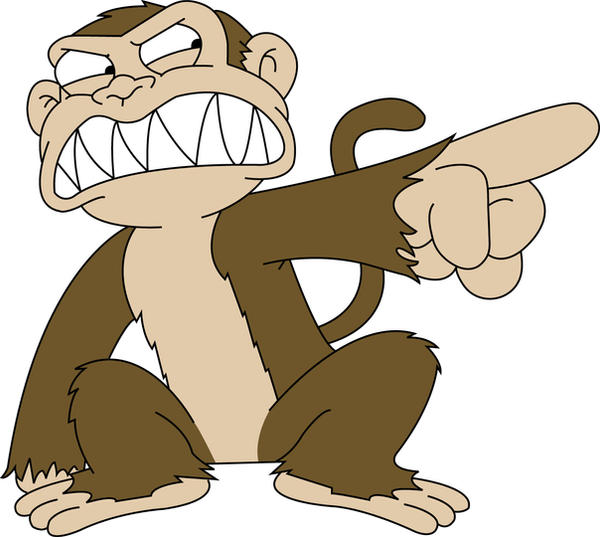

In [39]:
img = Image.open("/content/evil.jpg")
img

In [38]:
printProbs(img)

torch.Size([1, 577, 768]) torch.Size([1, 577, 768])
0: teddy, teddy_bear                             --- 0.2005
1: comic_book                                    --- 0.0479
2: pretzel                                       --- 0.0144
3: jigsaw_puzzle                                 --- 0.0130
4: ballplayer, baseball_player                   --- 0.0123
5: pug, pug-dog                                  --- 0.0123
6: Band_Aid                                      --- 0.0108
7: rubber_eraser, rubber, pencil_eraser          --- 0.0098
8: Chihuahua                                     --- 0.0092
9: shower_cap                                    --- 0.0084


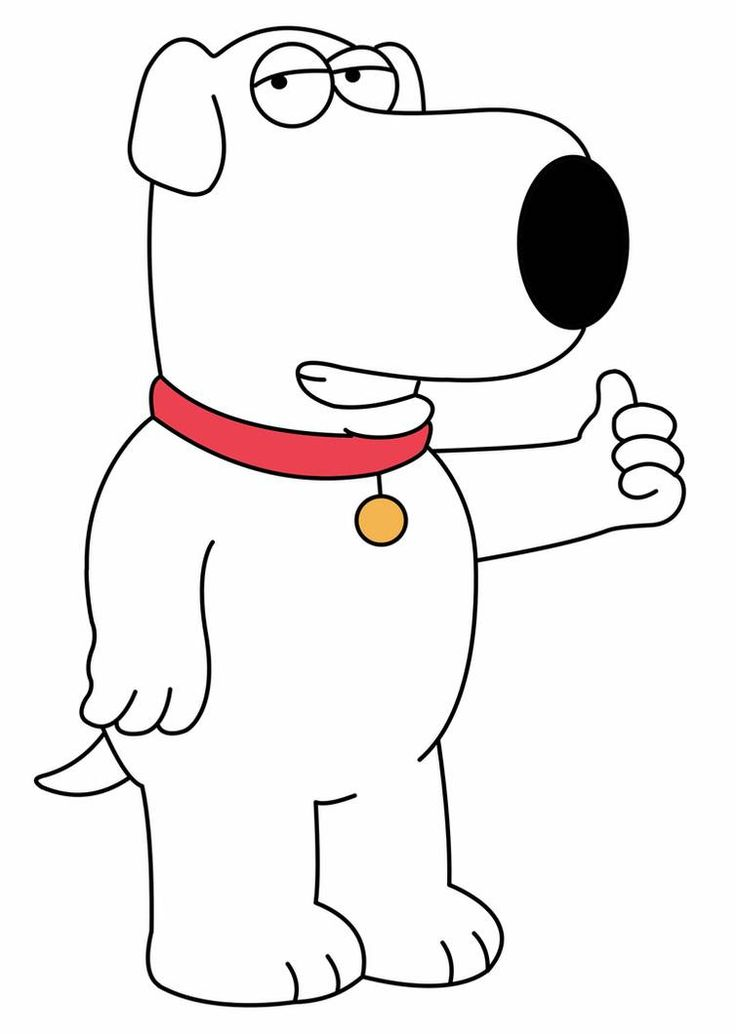

In [47]:
img = Image.open("/content/brain.jpg")
img

In [46]:
printProbs(img)

torch.Size([1, 577, 768]) torch.Size([1, 577, 768])
0: teddy, teddy_bear                             --- 0.1439
1: comic_book                                    --- 0.0538
2: plunger, plumber's_helper                     --- 0.0534
3: ballplayer, baseball_player                   --- 0.0337
4: envelope                                      --- 0.0324
5: paper_towel                                   --- 0.0302
6: rubber_eraser, rubber, pencil_eraser          --- 0.0297
7: soap_dispenser                                --- 0.0287
8: coffee_mug                                    --- 0.0186
9: can_opener, tin_opener                        --- 0.0169


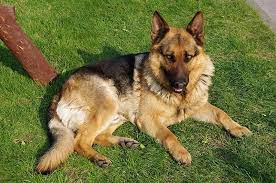

In [49]:
img = Image.open("/content/german.jpeg")
img

In [50]:
printProbs(img)

torch.Size([1, 577, 768]) torch.Size([1, 577, 768])
0: German_shepherd, German_shepherd_dog, German_police_dog, alsatian --- 0.9800
1: malinois                                      --- 0.0051
2: kelpie                                        --- 0.0017
3: bulletproof_vest                              --- 0.0008
4: muzzle                                        --- 0.0007
5: Leonberg                                      --- 0.0006
6: Norwegian_elkhound, elkhound                  --- 0.0005
7: dhole, Cuon_alpinus                           --- 0.0004
8: bloodhound, sleuthhound                       --- 0.0004
9: dingo, warrigal, warragal, Canis_dingo        --- 0.0004
